# Loading Libraries

In [4]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.split_utils import min_rating_filter_pandas

# Multi VAE Model
from recommenders.models.vae.multinomial_vae import Mult_VAE

# System & OS
import sys
import os

# Import & Read Dataset

In [5]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_train_mixed.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_test_mixed.csv", index_col=0)

In [6]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (287957, 3)
Shape of Test: 	 (71990, 3)


In [7]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3694
Unique Users in Test: 3694
Unique Items in Train: 2786
Unique Items in Test: 2786


In [8]:
# Concatenate both Dataset again for further Data Preparation
df = pd.concat([train, test], axis=0)

In [9]:
# Change name of columns 
df = df.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
df.columns

Index(['itemID', 'userID', 'rating'], dtype='object')

# Data Filtering 

In [10]:
# Binarize the data (only keep ratings >= 0.5)
df_preferred = df[df['rating'] > 0.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0.5]


# Head of df_preferred
df_preferred.head(10)

(259350, 3)


,itemID,userID,rating
171197,1917,441,1
219802,2369,145,1
239431,2855,4208,1
21619,386,3864,1
148454,1696,67,1
62494,925,2075,1
66142,976,3192,1
55056,870,2290,1
256582,3280,1009,1
51203,829,516,1


In [11]:
# Head of df_low_rating
df_low_rating.head(10)

,itemID,userID,rating
296882,2016,1620,0
262509,673,124,0
316340,1194,2475,0
346006,341,3758,0
307927,946,2099,0
335208,953,3290,0
355636,1130,4173,0
343479,3111,3645,0
318219,940,2564,0
348929,1394,3886,0


In [12]:
# Keep users who clicked on at least 5 items
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [13]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d interactions between %d users and %d items (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 259350 interactions between 3694 users and 2786 items (sparsity: 2.520%)


# Split Data

In [14]:
unique_users = sorted(df.userID.unique())
np.random.seed(1)
unique_users = np.random.permutation(unique_users)

In [15]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - 750 * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - 750 * 2) : (n_users - 750)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - 750):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 3694

Number of training users: 2194

Number of validation users: 750

Number of test users: 750


In [16]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])


Number of training observations:  155175

Number of validation observations:  54081

Number of test observations:  50094


In [17]:
# Obtain list of unique items used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that consumed in training set", unique_train_items.size)

Number of unique items that consumed in training set 2786


In [18]:
# For validation set keep only items that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies items used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  54081

Number of test observations after filtering:  50094


In [108]:
# Percentages of Datasets
print("Percentage Train Set:", train_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0]))
print("Percentage Validation Set:", val_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0]))
print("Percentage Test Set:", test_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0]))

Percentage Train Set: 0.5983227299016772
Percentage Validation Set: 0.20852515905147484
Percentage Test Set: 0.1931521110468479


# Click Matrix Generation

In [20]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [21]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(2194, 2786)
(750, 2786)
(750, 2786)


In [22]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=1)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=1)

In [23]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0.5)
val_data = binarize(a=val_data, threshold=0.5)
test_data = binarize(a=test_data, threshold=0.5)

In [24]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0.5)

In [25]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0.5)

In [26]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID'] # old value 
  item_old=i['itemID'] # old value 

  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old) # new value 
      item_new=test_map_items.get(item_old) # new value 
      rating=i['rating'] 
      test_data_te_ratings.at[user_new,item_new]= rating   

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old) # new value 
      item_new=val_map_items.get(item_old) # new value 
      rating=i['rating'] 
      val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    

# Shapes & Dimensions after Data Preparation

In [27]:
np.unique(test_data_tr)

array([0., 1.])

In [28]:
np.unique(train_data)

array([0., 1.])

In [29]:
np.unique(val_data)

array([0., 1.])

In [30]:
np.unique(val_data_tr)

array([0., 1.])

In [31]:
np.unique(test_data_te_ratings)

array([0, 1])

In [105]:
test_set.shape



(50094, 3)

In [106]:
val_set.shape

(54081, 3)

In [114]:
# Interactions in Train & Test of Val & Test 
print("Interactions in Validation Training",val_data_tr.sum())
print("Interactions in Validation Test",val_data_te.sum())
print("Interactions in Test Training",test_data_tr.sum())
print("Interactions in Test Test",test_data_te.sum())

Interactions in Validation Training 40548.0
Interactions in Validation Test 13533.0
Interactions in Test Training 37605.0
Interactions in Test Test 12489.0


In [116]:
test_data_tr.sum() / (test_data_tr.sum() + test_data_te.sum())

0.7506887052341598

# Baseline Model Multi VAE

In [32]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [33]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "svae_weights.hdf5")

In [44]:
model_without_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                   original_dim=train_data.shape[1], # Number of unique items in the training set
                                   intermediate_dim=1000, 
                                   latent_dim=50, 
                                   n_epochs=50, 
                                   batch_size=50, 
                                   k=100,
                                   verbose=0,
                                   seed=1,
                                   drop_encoder=0.5,
                                   drop_decoder=0.5,
                                   annealing=False,
                                   beta=1.0,
                                   save_path=WEIGHTS_PATH
                                   )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [45]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                        x_valid=val_data,
                        x_val_tr=val_data_tr, 
                        x_val_te=val_data_te_ratings, # with the original ratings 
                        mapper=am_val)
print("Took {} seconds for training.".format(t))

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
2023-06-06 12:11:01.926958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Took 113.3154 seconds for training.


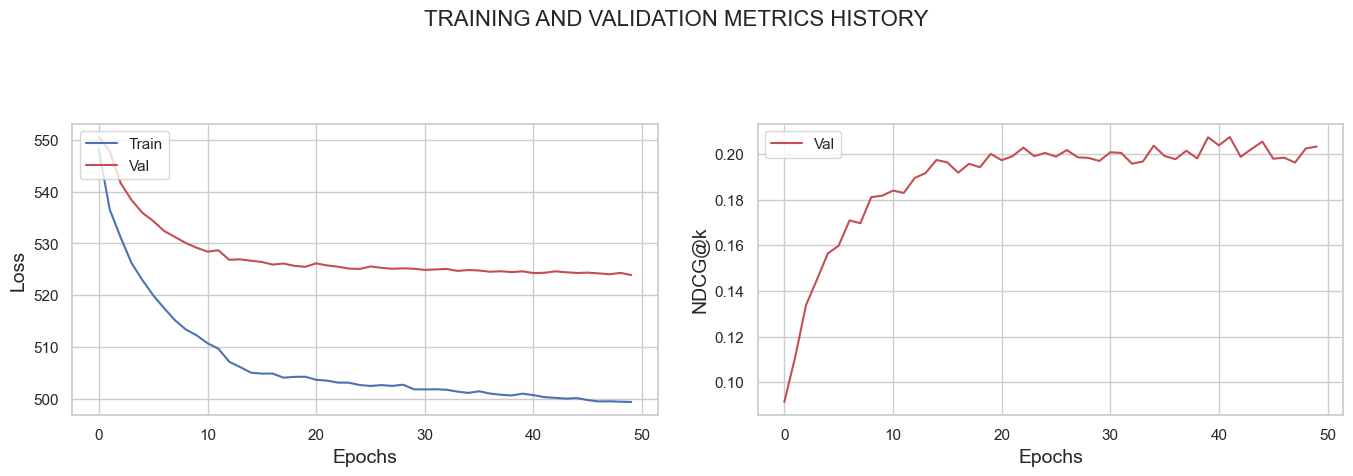

In [46]:
model_without_anneal.display_metrics() 

In [47]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 0.5052 seconds for prediction.
MAP@10:		0.040062
NDCG@10:	0.139382
Precision@10:	0.116533
Recall@10: 	0.087444


# Hyperparameter Tuning

In [49]:
# Set up Parameters
intermediate_dimension = [600, 800, 1000, 1200, 1400] 
latent_dimension = [50, 70, 90] 
batch_sizes = [50, 100]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = Mult_VAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.11895481262424266
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.17264289399057428


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08896501502407271
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.14406286638473223


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.10974994720884952
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.15928594464883308


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.09244366318882707
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.13177626425685365


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11349111415049053
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.17626056862484765


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.08541417922740989
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13663981416995644


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.1031448812234129
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.1643828544362976


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.08000451501232728
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.13676261202417128


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11198932806010756
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17841806931524104


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08693156700651453
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.13944200410296656


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.10615359803042455
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.1645081225018204


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.07799800200358693
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.12760666002604018


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12056962675118857
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.17287208937124887


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09123256411882483
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13484076277140847


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.11221832812268906
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.17121521434327713


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.09450427119805307
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.13780590137211016


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.1125080996411515
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.1752807649660374


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.08930616013081699
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13643632624963262


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.11278919756998118
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.1702149699532711


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.08665595278474394
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.14200224074544257


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.10826698627767732
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17029629676518493


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.09160017589871321
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.1378025141727671


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.10854772611386077
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.16257492690880265


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.07951391939706015
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.1303303045752076


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12053197498864794
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1814034397805691


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09240549386861815
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13585194678874268


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.11986681670214386
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.1750157932848737


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.08871805041302495
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.1313879343253667


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11450324732984841
Recall@20 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.17308973877202458


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.09493532585144643
Recall@20 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13872695650957068


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.10820340944202415
Recall@20 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.16836274426309894


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.09117722719737271
Recall@20 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.1397265054366323


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.1191378513648518
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17517460668866852


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08657362996027522
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.13673500333958077


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.11031530288952801
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.1632837806575978


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.08674425105653502
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.13574052735831146


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.11832035671672833
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.17613651291391336


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08902668788396265
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13204465926991812


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.1151712630604167
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.17358364971892984


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.09044046534077002
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.1347587172755065


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.1180779299405588
Recall@20 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.17769901291062834


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.08839554362629543
Recall@20 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13147196165242542


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.11235616207451968
Recall@20 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.1765633729103563


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.08736490621416641
Recall@20 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.1457158277938334


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11578221100214967
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17718011100470799


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08772020890224035
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.12946817587571907


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.11123702765289663
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.16741273456932926


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.08531203747182799
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.13530416730455233


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12194929898326214
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.18283853930363875


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09041462679325703
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.1417845973846449


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.11627355945668263
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.17453519063806167


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.09216449898896686
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.1404963981220172


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.12039925234998113
Recall@20 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.17292215840434327


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.0887357015305217
Recall@20 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.1373539755343824


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.11264361507265713
Recall@20 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.17633329224888114


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.08692620881705147
Recall@20 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.14311696908701826


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.12199006613730337
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17800341603367292


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.09152156958628466
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.13796045863158793


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.1055836502580015
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.16272974224860112


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.0883803914290598
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.12695577773746636


In [50]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_initial = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_initial.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
56,1400,90,True,50,0.121990,0.178003,0.150667,0.115533
48,1400,50,True,50,0.121949,0.182839,0.150400,0.119200
12,800,50,True,50,0.120570,0.172872,0.148400,0.113533
24,1000,50,True,50,0.120532,0.181403,0.147600,0.118267
52,1400,70,True,50,0.120399,0.172922,0.146000,0.115867
26,1000,50,True,100,0.119867,0.175016,0.146533,0.112200
32,1000,90,True,50,0.119138,0.175175,0.151067,0.113000
0,600,50,True,50,0.118955,0.172643,0.144533,0.111333
36,1200,50,True,50,0.118320,0.176137,0.145867,0.116000
40,1200,70,True,50,0.118078,0.177699,0.147733,0.117267


In [127]:
# Check Average Performance of Latent Dimensions
df_tuning_initial.groupby("latent_dimensions")['recall@10'].mean()

NameError: name 'df_tuning_initial' is not defined

In [126]:
# Check Average Performance of Latent Dimensions
df_tuning_initial.groupby("batch_size")['recall@10'].mean()

NameError: name 'df_tuning_initial' is not defined

# Hyperparameter Tuning 2.0 

In [34]:
# Set up Parameters
intermediate_dimension = [800, 900, 1000, 1100, 1200, 1300, 1400] 
latent_dimension = [50, 70, 90] 
batch_sizes = [50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = Mult_VAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
2023-06-06 20:58:56.313082: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 20:58:56.329042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will b

Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.11966215890068152
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1719870361911626


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08939595986848481
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13874480400852884


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11602133581444193
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.177684966360952


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.0819428448661541
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13072004267736204


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11268746249961191
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17348239628132145


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08803151196969262
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.13458028939954608


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1207194857344873
Recall@20 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.179391230151032


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08846115482679161
Recall@20 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13600764465050486


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11869027790692044
Recall@20 for Intermediate Dim:  900 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.1734007781746309


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.08648835255478103
Recall@20 for Intermediate Dim:  900 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.1346184256960254


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11104851781265346
Recall@20 for Intermediate Dim:  900 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17303184271792635


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08436629184109931
Recall@20 for Intermediate Dim:  900 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.1390102408011553


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12124388721024525
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.17618081644513486


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08735676127664234
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.14000029478340842


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11531363824971466
Recall@20 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.1741322128697101


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.08836653211273597
Recall@20 for Intermediate Dim:  1000 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13576326771499742


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11808132021217065
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.178794405219055


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.09024727208347946
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.14103575350703743


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.11927953465700855
Recall@20 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1769330701847313


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09184222582506377
Recall@20 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13439464873802057


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11774195997987624
Recall@20 for Intermediate Dim:  1100 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.16981038333132709


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.08718307983502825
Recall@20 for Intermediate Dim:  1100 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13681333003854973


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11707810922600813
Recall@20 for Intermediate Dim:  1100 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.1823387768691539


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08465525351587876
Recall@20 for Intermediate Dim:  1100 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.13471444618700826


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.11736318920185428
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.18092128618856948


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09296429766464427
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13816574942691018


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11539565085548152
Recall@20 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.17600651753697882


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.09271052066496047
Recall@20 for Intermediate Dim:  1200 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.1338692732832939


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11163660024505631
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17136288925925502


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08990964877824971
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.13427067069403092


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1300 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12059299048653895
Recall@20 for Intermediate Dim:  1300 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.17578000384013096


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1300 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09231945290415437
Recall@20 for Intermediate Dim:  1300 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.1351973418136778


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1300 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.12028555153775262
Recall@20 for Intermediate Dim:  1300 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.17454580659479382


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1300 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.09197513084035563
Recall@20 for Intermediate Dim:  1300 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13492303137470696


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1300 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11399588531262567
Recall@20 for Intermediate Dim:  1300 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17275306286641529


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1300 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08679797823791562
Recall@20 for Intermediate Dim:  1300 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.1338709063865593


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12206172060950667
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.18302281190292813


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09145016205637607
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13399809882088667


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.12151871334809501
Recall@20 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.17496071626799428


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.09243639706651474
Recall@20 for Intermediate Dim:  1400 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.13255882621023302


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.11937391539789544
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.17992404932274508


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.09159014579687146
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.13815661317486186


In [35]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
36,1400,50,True,50,0.122062,0.183023,0.147067,0.118067
38,1400,70,True,50,0.121519,0.174961,0.148133,0.113867
12,1000,50,True,50,0.121244,0.176181,0.148000,0.116000
6,900,50,True,50,0.120719,0.179391,0.147467,0.115600
30,1300,50,True,50,0.120593,0.175780,0.145733,0.117200
32,1300,70,True,50,0.120286,0.174546,0.148400,0.115600
0,800,50,True,50,0.119662,0.171987,0.148933,0.114000
40,1400,90,True,50,0.119374,0.179924,0.147867,0.115533
18,1100,50,True,50,0.119280,0.176933,0.146800,0.116867
8,900,70,True,50,0.118690,0.173401,0.146267,0.114667


In [121]:
# Average Performance based on Annealing
df_tuning_2.groupby("annealing")['recall@10'].mean().sort_values(ascending=False)

annealing
True     0.117609
False    0.089071
Name: recall@10, dtype: float64

In [120]:
# Difference in Average Performance based on Annealing
df_tuning_2.groupby("annealing")['recall@10'].mean().sort_values(ascending=False)[0] - df_tuning_2.groupby("annealing")['recall@10'].mean().sort_values(ascending=False)[1]

0.0285381395529882

In [124]:
# Average Performance based on Intermediate Dimension
df_tuning_2[df_tuning_2['annealing']==True].groupby("intermediate_dimensions")['recall@10'].mean().sort_values(ascending=False)

intermediate_dimensions
1400    0.120985
1300    0.118291
1000    0.118213
1100    0.118033
900     0.116819
800     0.116124
1200    0.114798
Name: recall@10, dtype: float64

In [125]:
# Average Performance based on Latent Dimension
df_tuning_2[df_tuning_2['annealing']==True].groupby("latent_dimensions")['recall@10'].mean().sort_values(ascending=False)

latent_dimensions
50    0.120132
70    0.117852
90    0.114843
Name: recall@10, dtype: float64

# Visualization of Hyperparameter Tuning

/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_25971/1097843002.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  marker=marker_shapes[annealing_value],


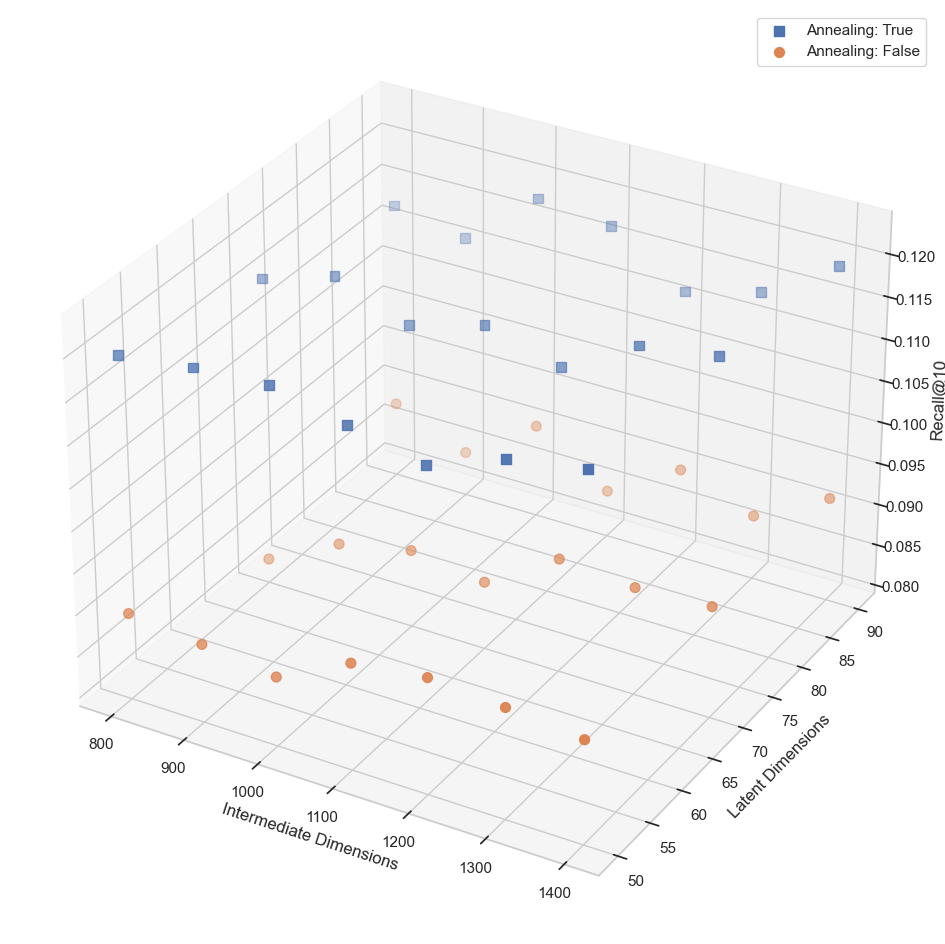

In [117]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x = df_tuning_2.intermediate_dimensions
y = df_tuning_2['latent_dimensions']
z = df_tuning_2['recall@10']
annealing = df_tuning_2['annealing']

ax.set_xlabel('Intermediate Dimensions', fontname='Arial', fontsize=12)
ax.set_ylabel('Latent Dimensions', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10', fontname='Arial', fontsize=12)

# Define different marker shapes based on the annealing values
marker_shapes = ['o', 's'] 

# Iterate over unique annealing values and plot each separately
for annealing_value in annealing.unique():
    indices = annealing == annealing_value
    ax.scatter(
        x[indices],
        y[indices],
        z[indices],
        marker=marker_shapes[annealing_value],
        s=50,
        label=f'Annealing: {annealing_value}'
    )

# Add a legend
ax.legend()

plt.show()


# Best Model

In [101]:
# Initiate Object for Model
best_model = Mult_VAE(n_users=train_data.shape[0],
                    original_dim=train_data.shape[1],
                    intermediate_dim=1400,
                    latent_dim=50,
                    n_epochs=20,
                    batch_size=50,
                    k=100,
                    verbose=0,
                    seed=1,
                    save_path=WEIGHTS_PATH,
                    drop_encoder=0.5,
                    drop_decoder=0.5,
                    annealing=True,
                    anneal_cap=1.0)

In [102]:
with Timer() as t:
    best_model.fit(x_train=train_data, 
                        x_valid=val_data,
                        x_val_tr=val_data_tr, 
                        x_val_te=val_data_te_ratings, # with the original ratings 
                        mapper=am_val)
print("Took {} seconds for training.".format(t))

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Took 107.4368 seconds for training.


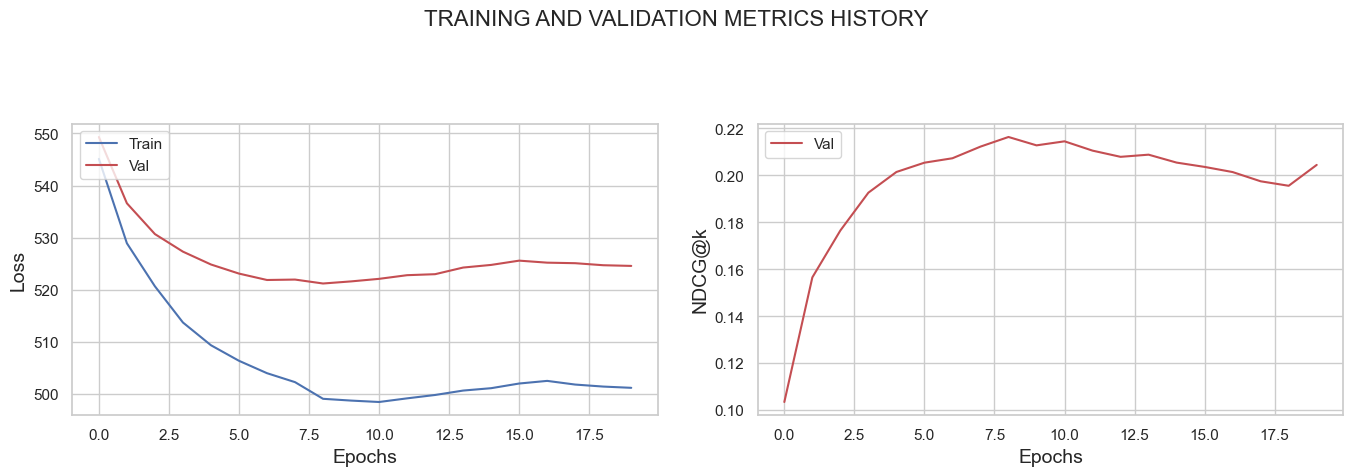

In [103]:
best_model.display_metrics() 